# Data Cleaning and Setup

In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn
seaborn.set(style='ticks')
import warnings
warnings.filterwarnings('ignore')
 
# Definfe the stock and ETFs universe
ETFs_universe = ['MGC', 'MGK', 'MGV', 'MTUM', 'QQQ', 'SDY', 'SPLV', 'VB', 
                 'VBK', 'VBR', 'VCR', 'VDC', 'VDE', 'VFH', 'VGT', 'VHT', 'VIG',
                 'VIS', 'VNQ', 'VO', 'VOE', 'VOT', 'VOX', 'VPU', 'VTV', 'VUG',
                 'VV', 'VYM', 'XBI', 'XLB', 'XLC', 'XLI', 'XLK', 'XLV', 'XME']


# Extract historiacl data from IEX
from iexfinance.stocks import get_historical_data
from iexfinance.stocks import Stock
from datetime import datetime
from datetime import timedelta
import os

# Authenticate the IEX with token
os.environ['IEX_API_VERSION'] = 'iexcloud-sandbox'
os.environ['IEX_TOKEN'] = 'Tpk_xxxxxxxx' # put your own token here

# Fetch the data from IEX
start_date = datetime.now() - timedelta(days = 365*10)
data = []

df = pd.DataFrame(columns=['symbol', 'fClose', 'changePercent'])
return_table = pd.DataFrame()

# Fetch the data

In [4]:
for s in ETFs_universe:
    df_extract = get_historical_data(s, start_date).loc[:, ['symbol', 'fClose', 'changePercent']]
    return_data = pd.to_numeric(df_extract.changePercent)
    return_table[s] = return_data
    df = df.append(df_extract)
    
# Change datatype into numeric
df.changePercent = pd.to_numeric(df.changePercent)
df.fClose = pd.to_numeric(df.fClose)
df.head()

,symbol,fClose,changePercent
2011-05-25,MGC,38.1134,0.0032
2011-05-26,MGC,38.5266,0.0040
2011-05-27,MGC,37.4111,0.0033
2011-05-31,MGC,39.3583,0.0111
2011-06-01,MGC,37.0882,-0.0218


# Ranking Analysis

In [5]:
return_table.head()

,MGC,MGK,MGV,MTUM,QQQ,SDY,SPLV,VB,VBK,VBR,...,VUG,VV,VYM,XBI,XLB,XLC,XLI,XLK,XLV,XME
2011-05-25,0.0032,0.0034,0.0030,NaN,0.0039,-0.0007,-0.0020,0.0105,0.0138,0.0081,...,0.0047,0.0033,0.0019,0.0160,0.0146,NaN,0.0087,0.0032,0.0014,0.0190
2011-05-26,0.0040,0.0049,0.0025,NaN,0.0063,0.0027,-0.0008,0.0123,0.0130,0.0100,...,0.0065,0.0047,0.0025,0.0089,0.0024,NaN,0.0041,0.0066,0.0014,0.0096
2011-05-27,0.0033,0.0046,0.0046,NaN,0.0050,0.0026,0.0040,0.0060,0.0071,0.0070,...,0.0039,0.0049,0.0025,0.0079,0.0109,NaN,0.0050,0.0050,0.0006,0.0104
2011-05-31,0.0111,0.0112,0.0106,NaN,0.0164,0.0096,0.0072,0.0130,0.0126,0.0117,...,0.0103,0.0105,0.0096,0.0077,0.0104,NaN,0.0093,0.0141,0.0118,0.0153
2011-06-01,-0.0218,-0.0219,-0.0226,NaN,-0.0220,-0.0197,-0.0121,-0.0299,-0.0322,-0.0286,...,-0.0220,-0.0227,-0.0170,-0.0258,-0.0323,NaN,-0.0341,-0.0208,-0.0139,-0.0365


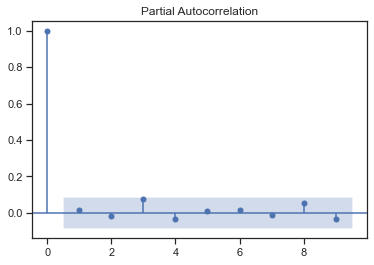

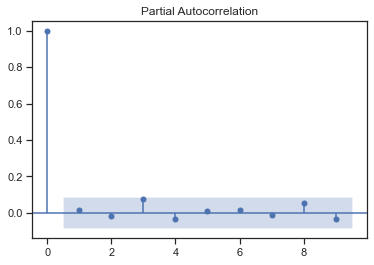

In [8]:
# Let's check the autocorrelation first

ranking_table = resample_risk_adjusted_retrun_table(return_table, 1).shift(1).rank(axis=1, na_option='keep', ascending = False) # one week look-back period, select top 2 ETFs
ranking_table.drop('XLC', inplace=True, axis=1)
ranking_table.dropna()

from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(x = ranking_table.MGK[1:], lags= np.arange(10) )

In [9]:
# Let's see the autocorrelation in the ranking time series data

lag1 = 0 
lag2 = 0
lag3 = 0 
count = 0 
for col in ranking_table.columns:
    lag1 += ranking_table[col][1:].autocorr(lag=1)
    lag2 += ranking_table[col][1:].autocorr(lag=2)
    lag3 += ranking_table[col][1:].autocorr(lag=3)
    count += 1

In [10]:
lag1/count

-0.0031118469493151275

In [11]:
lag2/count

0.021481260585947567

In [12]:
lag3/count

0.021261232595903085

Forecasting by LSTM model

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [14]:
class DataPreprocess():
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_len = seq_length
        self.trainX = None
        self.trainY = None
        self.testX = None
        self.testY = None
        self.scaler = None
        self.date = list(data.index)
        self.indexY = []

    def sliding_windows(self):
        x = []
        y = []
        for i in range(len(self.data)-self.seq_len):
            _x = self.data[i:(i+self.seq_len)]
            _y = self.data[i+self.seq_len]
            x.append(_x)
            y.append(_y)
            self.indexY.append(self.date[i+self.seq_len])
        return np.array(x),np.array(y)
    
    def split_train_test(self, split_percentage = 0.9):
        sc = MinMaxScaler()
        self.data = self.data.values.reshape(-1, 1)
        self.data = sc.fit_transform(self.data)
        self.scaler = sc 
        x, y = self.sliding_windows()

        train_size = int(len(y) * split_percentage)
        test_size = len(y) - train_size

        dataX = Variable(torch.Tensor(np.array(x)))
        dataY = Variable(torch.Tensor(np.array(y)))

        self.trainX = Variable(torch.Tensor(np.array(x[:train_size])))
        self.trainY = Variable(torch.Tensor(np.array(y[:train_size])))

        self.testX = Variable(torch.Tensor(np.array(x[train_size:])))
        self.testY = Variable(torch.Tensor(np.array(y[train_size:])))
        self.test_index = self.indexY[train_size:]

    def get_training_data(self):
        return self.trainX, self.trainY 
    
    def get_testing_data(self):
        return self.testX, self.testY



In [15]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [16]:
def training(model, num_epochs, learning_rate, trainX, trainY):
    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(num_epochs):
        outputs = model(trainX)
        optimizer.zero_grad()
        
        # obtain the loss function
        loss = criterion(outputs, trainY)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch+1, loss.item()))
    
def predict(model, testing_data, scaler):
    sc = MinMaxScaler()
    predict = model(testing_data)
    predict = predict.data.numpy()
    scaled_pred = scaler.inverse_transform(predict)
    pred_list = list(scaled_pred.reshape(1, -1)[0])
    return pred_list

In [17]:
clean_return_table = return_table.dropna(axis= 1, how = 'any')

In [26]:
num_epochs = 100
learning_rate = 0.001
input_size = 1
hidden_size = 32
num_layers = 1
num_classes = 1
models = {}
ts_data = {}
LSTM_prediction_return_table = pd.DataFrame()
for ticker in clean_return_table.columns:
    print(ticker)
    data = DataPreprocess(clean_return_table[ticker], 25)
    data.split_train_test()
    ts_data[ticker] = data
    lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
    training(lstm, num_epochs, learning_rate, data.trainX, data.trainY)
    models[ticker] = lstm
    pred = predict(lstm, data.testX, data.scaler)
    LSTM_prediction_return_table[ticker] = pred

MGC
Epoch: 100, loss: 0.00265
MGK
Epoch: 100, loss: 0.00275
MGV
Epoch: 100, loss: 0.00300
SDY
Epoch: 100, loss: 0.00273
SPLV
Epoch: 100, loss: 0.00207
VB
Epoch: 100, loss: 0.00317
VBK
Epoch: 100, loss: 0.00322
VBR
Epoch: 100, loss: 0.00327
VCR
Epoch: 100, loss: 0.00286
VDC
Epoch: 100, loss: 0.00244
VDE
Epoch: 100, loss: 0.00234
VFH
Epoch: 100, loss: 0.00305
VGT
Epoch: 100, loss: 0.00282
VHT
Epoch: 100, loss: 0.00356
VIG
Epoch: 100, loss: 0.00273
VIS
Epoch: 100, loss: 0.00289
VNQ
Epoch: 100, loss: 0.00234
VO
Epoch: 100, loss: 0.00268
VOE
Epoch: 100, loss: 0.00263
VOT
Epoch: 100, loss: 0.00272
VOX
Epoch: 100, loss: 0.00321
VPU
Epoch: 100, loss: 0.00228
VTV
Epoch: 100, loss: 0.00277
VUG
Epoch: 100, loss: 0.00291
VV
Epoch: 100, loss: 0.00255
VYM
Epoch: 100, loss: 0.00289
XBI
Epoch: 100, loss: 0.00791
XLB
Epoch: 100, loss: 0.00351
XLI
Epoch: 100, loss: 0.00282
XLK
Epoch: 100, loss: 0.00256
XLV
Epoch: 100, loss: 0.00390
XME
Epoch: 100, loss: 0.00563


In [27]:
LSTM_prediction_return_table['index'] = pd.to_datetime(ts_data[ticker].test_index)
LSTM_prediction_return_table = LSTM_prediction_return_table.set_index('index')

In [28]:
LSTM_prediction_return_table

,MGC,MGK,MGV,SDY,SPLV,VB,VBK,VBR,VCR,VDC,...,VTV,VUG,VV,VYM,XBI,XLB,XLI,XLK,XLV,XME
index,,,,,,,,,,,,,,,,,,,,,
2020-05-26,0.001410,0.002500,0.000070,0.001168,0.001261,0.002630,0.001996,0.003049,0.002914,0.000699,...,-0.000217,0.002135,0.001849,0.001208,-0.000020,0.000747,0.000817,0.002409,0.000910,-0.000649
2020-05-27,0.001725,0.002418,0.000623,0.002234,0.001521,0.003244,0.002201,0.004034,0.003428,0.000915,...,0.000474,0.002039,0.002026,0.001841,-0.001157,0.001108,0.002117,0.002153,0.000824,-0.000013
2020-05-28,0.002005,0.002430,0.001098,0.002782,0.002081,0.003750,0.002303,0.004779,0.003846,0.001523,...,0.001126,0.002119,0.002242,0.002344,-0.001253,0.001166,0.002659,0.002371,0.001451,0.000956
2020-05-29,0.001633,0.002394,0.000776,0.001958,0.002211,0.003022,0.001658,0.003875,0.002585,0.001782,...,0.000871,0.002036,0.002106,0.002031,-0.001714,0.001203,0.001497,0.002063,0.002137,-0.000199
2020-06-01,0.001714,0.002453,0.000585,0.001448,0.002288,0.002632,0.001973,0.003131,0.002695,0.001801,...,0.000687,0.002173,0.002100,0.001914,-0.001345,0.001059,0.000881,0.002716,0.002594,-0.000554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-14,0.000735,0.000727,-0.000110,0.000643,0.001421,0.000133,0.000641,0.001348,0.000282,0.000761,...,-0.000641,-0.000114,0.001066,0.001154,-0.003052,0.000517,0.000277,0.000206,0.000997,-0.000960
2021-05-17,0.001294,0.001273,0.000171,0.000907,0.001566,0.000979,0.001784,0.001998,0.001678,0.001044,...,-0.000327,0.000936,0.001473,0.001441,-0.001398,0.000703,0.000736,0.001924,0.001268,-0.000347
2021-05-18,0.001027,0.001462,0.000129,0.000759,0.001421,0.001119,0.001122,0.002155,0.001517,0.001035,...,-0.000268,0.000944,0.001444,0.001392,-0.001378,0.000829,0.000455,0.001424,0.001133,0.001061


# Forecasting the daily return by TFT model 

In [21]:
import torch 
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss
import pytorch_lightning as pl

# hyperparameter here is being tuned, please remember the value before trying to change anything here

# Pytorch Lighting is a high-level interface fro PyTorch
# PyTorch Forecasting is a time series prediction package based on PyTorch and PyTorch Lighting
# Check the followong link for more infomation regarding to the model and hyperparameter

# For PyTorch Forecasting example
# https://bit.ly/31SpgPc

# For TFT model
# https://bit.ly/3cZaTPr

# For loss function and QuantileLoss
# https://bit.ly/2Q6htdQ
# https://bit.ly/3uysXpr

# For hyperparameter in TemporalFusionTransformer
# https://bit.ly/2RjZAZJ

# For hyperparameter in TimeSeriesDataSet
# https://bit.ly/3d0s82N

class TimeSeriesPredictionModel:
    def __init__(self, table, target, columns, split_percent = 0.9, num_days = 15):
        self.train_num = int(len(table)*split_percent)
        self.dataset = table[columns]
        self.dataset = self.dataset.reset_index()
        self.dataset['time_idx'] = range(len(self.dataset))
        self.date_mapping = list(self.dataset['index'])
        self.dataset['group'] = 0
        self.num_days = num_days
        self.target = target
        self.considered_ts = columns 
        self.training_set = self.datasetToTimeseriesdataset(self.dataset[:self.train_num])
        self.val_set = self.datasetToTimeseriesdataset(self.dataset[self.train_num:])
        self.test_set = self.datasetToTimeseriesdataset(self.dataset[self.train_num:], True)
        self.model = self.buildModel()
        
    def datasetToTimeseriesdataset(self, ds, prediction_mode = False):
        return TimeSeriesDataSet(
            ds,
            group_ids=['group'],
            target=self.target,
            time_idx="time_idx",
            min_encoder_length=self.num_days,
            max_encoder_length=self.num_days,
            min_prediction_length=1,
            max_prediction_length=1,
            time_varying_unknown_reals=self.considered_ts,
            time_varying_known_reals=['time_idx'],
            predict_mode = prediction_mode
        )
    
    def buildModel(self):
        return TemporalFusionTransformer.from_dataset(
         self.training_set,
         learning_rate=0.001,
         hidden_size=16,  # biggest influence network size
         attention_head_size=2,
         dropout=0.5,
         lstm_layers = 2, 
         hidden_continuous_size=8,
         output_size=1, 
         loss=QuantileLoss([0.5]), # mean absolute error 
         reduce_on_plateau_patience=4,  # reduce learning automatically
        )
    
    def trainModel(self, num_epoch, batch_size):
        dataloader_train = self.training_set.to_dataloader(batch_size=batch_size)
        dataloader_val = self.val_set.to_dataloader(batch_size=batch_size)
        trainer = pl.Trainer(
         max_epochs=num_epoch,
         gpus=0,  
         gradient_clip_val=0.1,
         limit_train_batches=20,  # running validation for every 20 batches
         num_sanity_val_steps = 0,
     )
        trainer.fit(
         self.model,
         train_dataloader=dataloader_train,
         val_dataloaders=dataloader_val
        ) 
    
    def predict(self):
        dataloader = tsmodel.val_set.to_dataloader(batch_size = 1, shuffle = False )
        return_list = []
        date_list = []
        for x, y in dataloader:
            return_list.append(self.model(x)['prediction'].item())
            idx = int(self.val_set.x_to_index(x).time_idx)
            date_list.append(self.date_mapping[idx])
        pred_df = pd.DataFrame( {'date':date_list, 'return':return_list})
        return pred_df
        

# Retrun Prediction

In [22]:
# normalize the data

# for proper compliable with activation function, remember to normalize the data(retrun table here) before put into
# model

normalized_table = (return_table - return_table.mean())/return_table.std()
normalized_table = normalized_table.fillna(0)

In [23]:
## train the model

# input: return table, the stock return we want to predict, reference data, training data percentage, look-back period.
# for example, I want to predict the retrun of MGC hear, use all the return data available in the return table
# take 90% of data as trainging dataset, latter 10% of data as validation dataset

ticker_models = {}
ticker_prediction = {}
for ticker in normalized_table.columns:
    tsmodel = TimeSeriesPredictionModel(normalized_table, ticker, list(normalized_table.columns), 0.9 , 25)
    tsmodel.trainModel(1, 4)
    pred = tsmodel.predict()
    ticker_models[ticker] = tsmodel 
    ticker_prediction[ticker] = pred

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 576   
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 25.6 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | 

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [47]:
# construct the predict return table

results = pd.DataFrame()
results['index'] = ticker_prediction["MGC"].date # store the datetime index out
for ticker in normalized_table.columns:
    results[ticker] = ticker_prediction[ticker]['return']

results = results.set_index('index')
TFT_prediction_return_table = results*return_table.std()+return_table.mean()
TFT_prediction_return_table

,MGC,MGK,MGV,MTUM,QQQ,SDY,SPLV,VB,VBK,VBR,...,VUG,VV,VYM,XBI,XLB,XLC,XLI,XLK,XLV,XME
index,,,,,,,,,,,,,,,,,,,,,
2020-06-25,0.000856,-0.009310,-0.006284,0.003628,0.000270,0.000895,-0.008865,0.000833,-0.009346,-0.000532,...,0.009908,-0.000568,-0.006539,0.004950,-0.006312,0.000127,0.003023,-0.004129,-0.004153,0.005199
2020-06-26,-0.001778,-0.008130,-0.003987,0.009271,-0.000114,0.005376,-0.011250,-0.000977,-0.000810,0.000998,...,0.011910,-0.004081,-0.005186,0.000307,-0.002221,-0.001499,0.006694,-0.003203,-0.002957,0.006268
2020-06-29,-0.002812,-0.001662,-0.010146,0.000138,0.000880,0.004700,-0.007005,-0.004617,-0.013294,-0.000756,...,0.003241,-0.004096,-0.008306,0.000745,-0.013933,-0.000163,0.005974,-0.002467,-0.011271,0.005127
2020-06-30,-0.002512,-0.008015,-0.008961,0.003307,-0.004162,0.004530,-0.011288,0.002361,-0.003974,-0.004726,...,0.009798,-0.003751,-0.006481,0.000561,-0.008526,-0.002142,0.002079,-0.000775,-0.010873,0.002164
2020-07-01,0.006809,0.000129,-0.005559,-0.002175,-0.000883,0.006967,-0.009667,-0.001943,-0.012710,-0.002717,...,0.008861,0.000954,-0.006437,-0.002852,-0.004039,-0.001100,-0.001498,0.000165,-0.004460,0.006740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-14,-0.009517,-0.006189,-0.012445,-0.010716,-0.001037,0.002298,-0.002194,-0.000898,-0.005536,-0.003173,...,0.010783,-0.004209,-0.006504,-0.003212,-0.004006,0.006548,0.000540,0.007758,0.000958,-0.011646
2021-05-17,-0.009388,-0.008159,-0.013902,-0.009625,0.001594,-0.002316,-0.001743,0.001016,0.006634,-0.008765,...,0.008101,0.004621,-0.003095,-0.008591,-0.004417,0.015344,-0.000578,0.006084,0.001691,-0.011207
2021-05-18,-0.012864,-0.009536,-0.013682,-0.011535,-0.002622,-0.009693,-0.000971,0.000647,-0.001858,-0.005807,...,0.010927,0.000225,-0.004797,-0.013143,0.005745,0.009544,-0.002432,0.004554,0.004658,-0.004678


# Momemtum Filter

In [41]:
def momemtum_ranking_table(df, t, n):
    # lookback period = t weeks
    # select top n stock
    
    # create a ranking table (smaller the ranking, higher the return)
    ranking = resample_risk_adjusted_retrun_table(df, t).shift(1).rank(axis=1, na_option='keep', ascending = False)
    original_rank = list(range (1, len(df.columns)+1))
    replace_rank = [1]*n + [0]*(len(df.columns)-n)

    ranking_matrix = ranking.replace(original_rank, replace_rank)# replace_rank
    return ranking_matrix

def cumulative_return(return_vals):
    cumulative_return_list = (np.array(return_vals)+1).cumprod() -1
    
    return cumulative_return_list[-1]

def resample_retrun_table(df, t):
    # df is the daily return table
    # t is the number of week we want to resample into
    df = df.fillna(0)
    df = df.resample("W-Fri").apply(lambda x : cumulative_return(x)) # turn the dataframe into weekly 
    index = df.index # store the weekly datetime index
    df = df.reset_index().drop(columns=['index'])

    rolling_return = (1 + df).rolling(window = t).apply(np.prod, raw = True) - 1
    rolling_return = rolling_return.set_index([index])
    return rolling_return.iloc[::-1].iloc[::t, :].iloc[::-1] # turn the table upside dowm, then select every t-th row, the turn around the table again 

def resample_risk_adjusted_retrun_table(df, t):
    # for ranking propose, we need risk adjusted return
    df = df.fillna(0)
    idx = pd.date_range(df.index[0], df.index[-1])
    
    risk = df.reindex(idx, fill_value=0).rolling(window=t*5).std()
    df = df.resample("W-Fri").apply(lambda x : cumulative_return(x))# turn the dataframe into weekly
    index = df.index # store the weekly datetime index
    df = df.reset_index().drop(columns=['index'])
    
    rolling_return = (1 + df).rolling(window = t).apply(np.prod, raw = True) - 1
    rolling_return = rolling_return.set_index([index])
    resample_return_table = rolling_return.iloc[::-1].iloc[::t, :].iloc[::-1]
    multrisk = resample_return_table.mul(1/risk).dropna(how='all') # multiply element-wise 
    # using ,mul instead of np.multiply, and you can multiply 2 dataframe with different dimension
    return multrisk

def portfolio_retrun_table(df, t, n):
    return momemtum_ranking_table(df, t, n).mul(resample_retrun_table(df, t)).sum(1)*(1/n) # equal weighted here

def momemtum_ranking_table_for_predict_return(df, t, n):
    
    ranking = resample_risk_adjusted_retrun_table(df, t).rank(axis=1, na_option='keep', ascending = False)
    original_rank = list(range (1, len(df.columns)+1))
    replace_rank = [1]*n + [0]*(len(df.columns)-n)

    ranking_matrix = ranking.replace(original_rank, replace_rank)# replace_rank
    return ranking_matrix
    
def portfolio_retrun_table_for_prediction(original_df, predict_df, t, n):
    return momemtum_ranking_table_for_predict_return(predict_df, t, n).mul(resample_retrun_table(original_df, t)).sum(1)*(1/n) # equal weighted here
    
def plot_maximum_drawdown(df, t, n):
    wealth_index=(1+portfolio_retrun_table(df,t,n)).cumprod()
    plt.plot(wealth_index)
    previous_peaks = pd.Series(wealth_index).cummax()
    previous_peaks.plot()

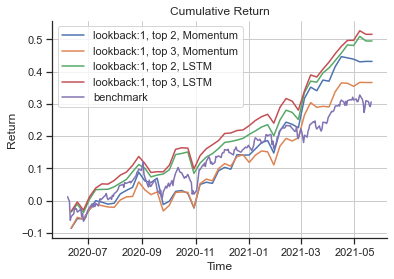

In [46]:
# Backtesting

fig, ax = plt.subplots()
ax.set_title('Cumulative Return')

ax.set(xlabel='Time', ylabel='Return')
ax.grid(True, which='both')
seaborn.despine(ax=ax, offset=0) # the important part here


df = return_table
for t in [1]:
    for n in [2,3]:
            
        # '2011-06-03' need manuualy input when you select the differnet timeframe
        data = (1+ portfolio_retrun_table(df, t, n).loc[portfolio_retrun_table(df, t, n).index > '2020-06-05']).cumprod()-1

        ax.plot(data, label = 'lookback:' + str(t) + ", top " + str(n) + ", Momentum")
        ax.legend()

        
predict_df = LSTM_prediction_return_table
original_df = return_table
for t in [1]:
    for n in [2,3]:
            
        # '2011-06-03' need manuualy input when you select the differnet timeframe
        data = (1+ portfolio_retrun_table_for_prediction(original_df, predict_df, t, n).loc[portfolio_retrun_table_for_prediction(original_df, predict_df, t, n).index > '2020-06-05']).cumprod()-1

        ax.plot(data, label = 'lookback:' + str(t) + ", top " + str(n) + ", LSTM")
        ax.legend()

        
# Add benchmark

df_extract = get_historical_data('SPY', start_date).loc[:, ['symbol', 'fClose', 'changePercent']]
benchmark_return = pd.to_numeric(df_extract.changePercent)

benchmark_data = (1+benchmark_return.loc[benchmark_return.index > '2020-06-05']).cumprod()-1
ax.plot(benchmark_data, label = 'benchmark')
ax.legend()

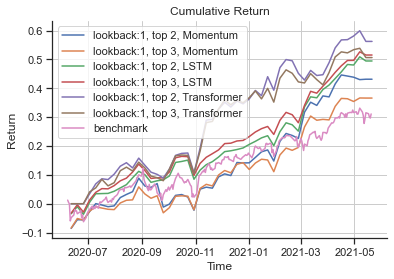

In [51]:
fig, ax = plt.subplots()
ax.set_title('Cumulative Return')

ax.set(xlabel='Time', ylabel='Return')
ax.grid(True, which='both')
seaborn.despine(ax=ax, offset=0) # the important part here


df = return_table
for t in [1]:
    for n in [2,3]:
            
        # '2011-06-03' need manuualy input when you select the differnet timeframe
        data = (1+ portfolio_retrun_table(df, t, n).loc[portfolio_retrun_table(df, t, n).index > '2020-06-05']).cumprod()-1

        ax.plot(data, label = 'lookback:' + str(t) + ", top " + str(n) + ", Momentum")
        ax.legend()

        
predict_df = LSTM_prediction_return_table
original_df = return_table
for t in [1]:
    for n in [2,3]:
            
        # '2011-06-03' need manuualy input when you select the differnet timeframe
        data = (1+ portfolio_retrun_table_for_prediction(original_df, predict_df, t, n).loc[portfolio_retrun_table_for_prediction(original_df, predict_df, t, n).index > '2020-06-05']).cumprod()-1

        ax.plot(data, label = 'lookback:' + str(t) + ", top " + str(n) + ", LSTM")
        ax.legend()
        
        
predict_df = TFT_prediction_return_table
original_df = return_table
for t in [1]:
    for n in [2,3]:
            
        # '2011-06-03' need manuualy input when you select the differnet timeframe
        data = (1+ portfolio_retrun_table_for_prediction(original_df, predict_df, t, n).loc[portfolio_retrun_table_for_prediction(original_df, predict_df, t, n).index > '2020-06-05']).cumprod()-1

        ax.plot(data, label = 'lookback:' + str(t) + ", top " + str(n) + ", Transformer")
        ax.legend()

        
# Add benchmark

df_extract = get_historical_data('SPY', start_date).loc[:, ['symbol', 'fClose', 'changePercent']]
benchmark_return = pd.to_numeric(df_extract.changePercent)

benchmark_data = (1+benchmark_return.loc[benchmark_return.index > '2020-06-05']).cumprod()-1
ax.plot(benchmark_data, label = 'benchmark')
ax.legend()